<h1>Marketing Attribution 
Analysis and Root Cause Analysis</h1>
<h3>For an e-commerce site</h3>

                                                                                                        Author: Mei Mei
                                                                                                        Date: 1/29/2020

<b>This notebook is aiming at solving two problems:</b>

<b>Part 1.</b> Marketing attribution anaysis for users

<b>Part 2.</b> Low sales analysis with method of time series forecast & root cause analysis


# <h2>Part 1</h2> 

In [1]:
import pandas as pd
from datetime import datetime
import datetime
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
import warnings
plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
#Load four tables into pandas dataframe. 
device = pd.read_csv('device.csv')
user = pd.read_csv('user.csv')
user_device = pd.read_csv('user_device.csv')
attribution = pd.read_csv('attribution.csv')

#### Table join1 is joined by Table user & Table user_device.
#### Table join2 is joined by Table join1 & Table device.

In [3]:
join1 = pd.merge(
                    user_device,
                    user,
                    left_on = 'user_id',
                    right_on = 'id',
                    how = 'inner')

join2 = pd.merge(
                    join1,
                    device,
                    left_on = 'device_id',
                    right_on = 'id',
                    how = 'left')

In [4]:
# By noticing time difference between device creation and user creation 
# is always less than 1 day, we can use this finding to assign user to
# the right device. 
join2['user_create'] = pd.to_datetime(join2['created_on_x'])
join2['device_create'] = pd.to_datetime(join2['created_on_y'])
join2['user_device_diff'] = abs(join2['user_create'] - join2['device_create'])
join2.drop(join2[join2.user_device_diff > datetime.timedelta(days=1)].index, inplace=True)

# Delete duplicate columns
join2.drop(['id_x', 'id_y', 'created_on_x', 'created_on_y'], axis=1, inplace = True)

# Create an index for Table attribution 
attribution['attribution_id'] = range(0, len(attribution))

#### Table join3 is joined by Table join2 & Table attribution.

In [5]:
join3 = pd.merge(
                    join2,
                    attribution,
                    left_on = 'device_id',
                    right_on = 'device_id',
                    how = 'left')

# Drop rows with missing data
join3.dropna(inplace = True)
join3['created_on'] = pd.to_datetime(join3['created_on'])
join3['campaign_device_diff'] = join3['device_create'] - join3['created_on']
join3.rename(columns = {'created_on':'campaign_create'}, inplace =True)

### Question 1: What attribution logic do you use? 

Attribute campaign to each user we have in Table join2, which is backward attribution logic. Backward logic focuses on finding the campaign that helps us getting the users, and it helps us understand the importance of each campaign, e.g. which marketing partner should we give credit to. 

Backward logic is good for giving credit to each campaign. We will get a clear idea of where our users are coming from. And invest more campaigns that have higher conversion rate. 

Forward logic is good for planning for future campaign and marketing, we can get detailed information of conversion rate and profits from each campaign. And we can invest in our future marketing in a more effective way. 

In [6]:
join3 = join3[join3.campaign_device_diff > datetime.timedelta(seconds=1)]
join3 = join3[join3.campaign_device_diff < datetime.timedelta(days=30)]

### Question 2: How much time will you allow between the attribution and user creation? 
#### In my analysis, the allowed time difference between attribution and user creation is one month. In the code, it's more than 1 sec and less than one month. To attribute a user to a campaign, the campaign must happen before user creation, and within one month, this campaign can still affect the target user and convert them. However a more precise way is to getting a referral feature from the original user creation data. For example, in the user table, there is a column called referral, values could be: organic google, google ads, facebook etc. 

### Insight: 
There are 100 unique campaign in total and the one that convert the most users are 5IHLGC and it converted 34 users.

In [7]:
join3['campaign'].describe()

count       2178
unique       100
top       5IHLGC
freq          34
Name: campaign, dtype: object

### Insight: 
The top ten campaign converted the most users are the ones below.

In [8]:
join3.groupby('campaign')['user_id'].count().nlargest(10)

campaign
5IHLGC    34
9VTGJV    33
6H7SPL    32
6XC4I2    30
CPIAHO    29
ZZGRSM    29
OGMRY2    28
OKAJCV    28
RK2JMQ    28
XUL7TT    28
Name: user_id, dtype: int64

## Question 3: What campaign was responsible for each user's finding our app? 
#### See the table below, there are 2178 attributions we can track in total. 

In [11]:
join3

,device_id,user_id,name,device_type,operating_system,user_create,device_create,user_device_diff,campaign_create,campaign,attribution_id,campaign_device_diff
0,1,0,mufeelm,iOS,7,2017-02-15 19:39:10.100,2017-02-15 10:19:43.100,09:19:27,2017-02-15 10:19:00,I5UB5Y,2378.0,0 days 00:00:43.100000
2,3,2,cvgpmcv,iOS,8,2017-02-06 19:25:48.100,2017-02-06 04:40:31.100,14:45:17,2017-02-06 04:40:00,9VTGJV,1573.0,0 days 00:00:31.100000
3,4,2,jmhkmma,Android,KitKat,2016-09-22 22:25:50.200,2016-09-22 06:29:17.200,15:56:33,2016-09-22 06:28:00,VR88YD,2089.0,0 days 00:01:17.200000
4,6,3,bjzqbft,iOS,20,2016-07-11 10:36:58.200,2016-07-11 06:16:20.200,04:20:38,2016-07-11 06:16:00,72C6Y3,954.0,0 days 00:00:20.200000
6,7,4,zgwqnve,Amazon Fire,Fire1,2015-02-23 20:42:12.600,2015-02-23 19:38:22.600,01:03:50,2015-02-23 19:38:00,TI1ZOJ,175.0,0 days 00:00:22.600000
13,11,9,auqvkzd,iOS,7,2015-11-14 23:53:11.400,2015-11-14 10:27:15.400,13:25:56,2015-11-14 10:27:00,EH7LXL,2696.0,0 days 00:00:15.400000
15,13,10,gciigjv,iOS,8,2016-11-06 07:15:00.100,2016-11-06 06:39:52.100,00:35:08,2016-11-06 06:39:00,GCP82I,3036.0,0 days 00:00:52.100000
17,14,10,gulftnv,iOS,10,2016-12-16 12:26:32.100,2016-12-15 22:23:46.100,14:02:46,2016-12-15 22:23:00,RU7BDI,1893.0,0 days 00:00:46.100000
19,16,11,uxrjlai,Amazon Fire,Fire2,2016-05-29 14:11:56.300,2016-05-29 03:46:47.300,10:25:09,2016-04-29 18:30:00,15R3D0,4210.0,29 days 09:16:47.300000
20,17,12,bsuoonx,Android,Marshmallow,2017-01-15 04:21:42.100,2017-01-15 01:52:01.100,02:29:41,2017-01-15 01:51:00,GCP82I,2082.0,0 days 00:01:01.100000


<h2>Part 2</h2>

### Question 4: It looks like sales have been a bit low the last couple of days of the sales data set. Is this something we should be worried about? 

### Explore the Table sales and reavel the trend, seasonality etc.

In [14]:
sale_raw = pd.read_csv('sale.csv', parse_dates = ['date'])
sale_raw.drop_duplicates(inplace = True)
cols = ['created_on', 'user_id', 'id', 'weekday']
sale = sale_raw
sale.drop(cols, axis=1, inplace = True)
sale = sale_raw.sort_values('date')
sale = sale.groupby('date')['amount'].sum().reset_index()
sale = sale.set_index('date')
y = sale['amount'].resample('MS').mean()

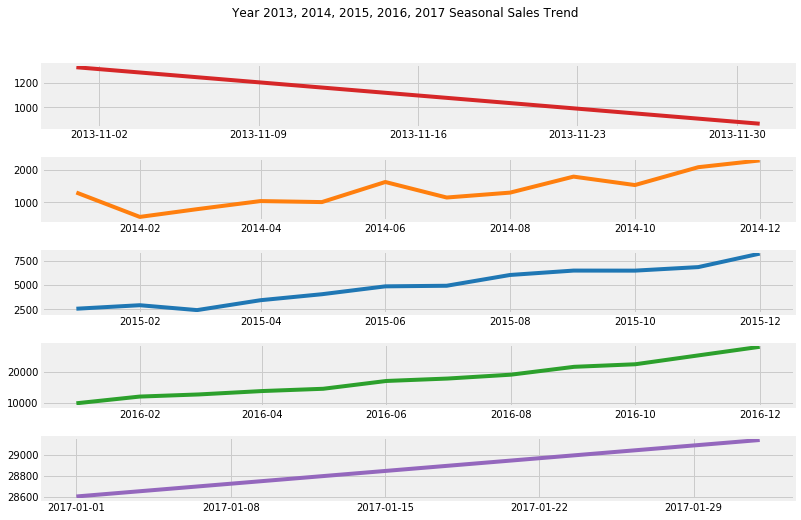

In [15]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,  figsize = (12, 8), gridspec_kw={'hspace': 0.5})
fig.suptitle('Year 2013, 2014, 2015, 2016, 2017 Seasonal Sales Trend')
ax1.plot(y['2013'], 'tab:red')
ax2.plot(y['2014'], 'tab:orange')
ax3.plot(y['2015'], 'tab:blue')
ax4.plot(y['2016'], 'tab:green')
ax5.plot(y['2017'], 'tab:purple')

#### From the plots above we could see there is a seasonality pattern in the time series data, such as sales are always low at the beginning of the year and high at the end of the year. This data follows non-stational time series. 
#### There is always a strong upward trend within any single year with a couple of low months in the mid of the year. 
#### Exception is the first year which only has two months on record with a lot of missing data. 


### Time-series decomposition

Get plots of trend, seasonality and noise.

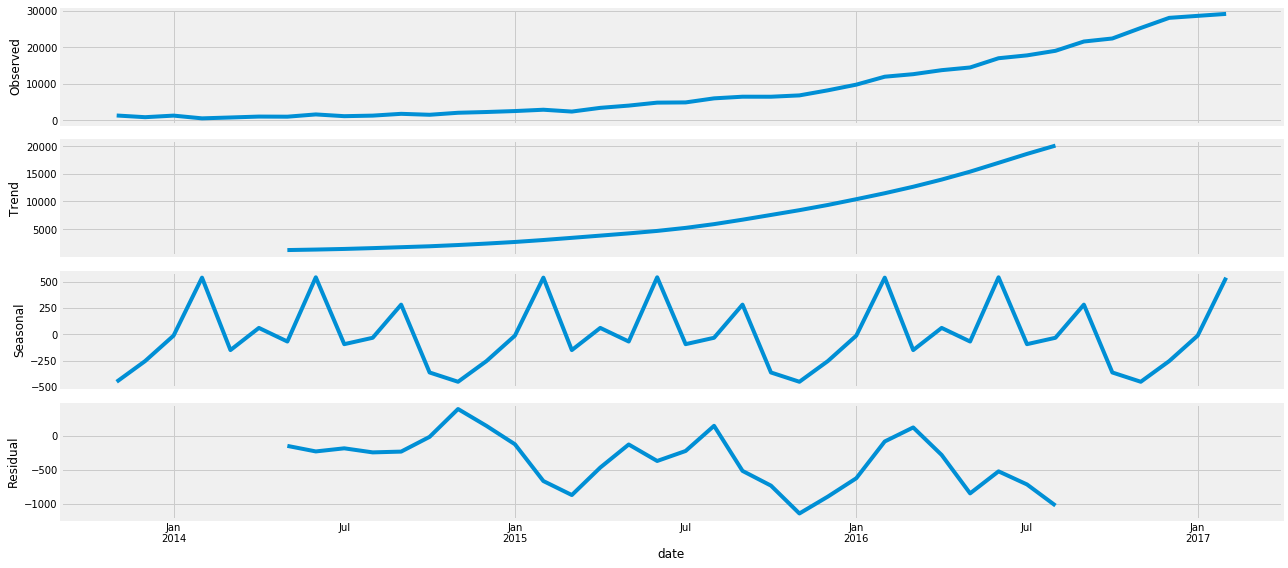

In [16]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#### These plots above showed sales is unstable on this e-commerce site and we could see obvious seasonality. 

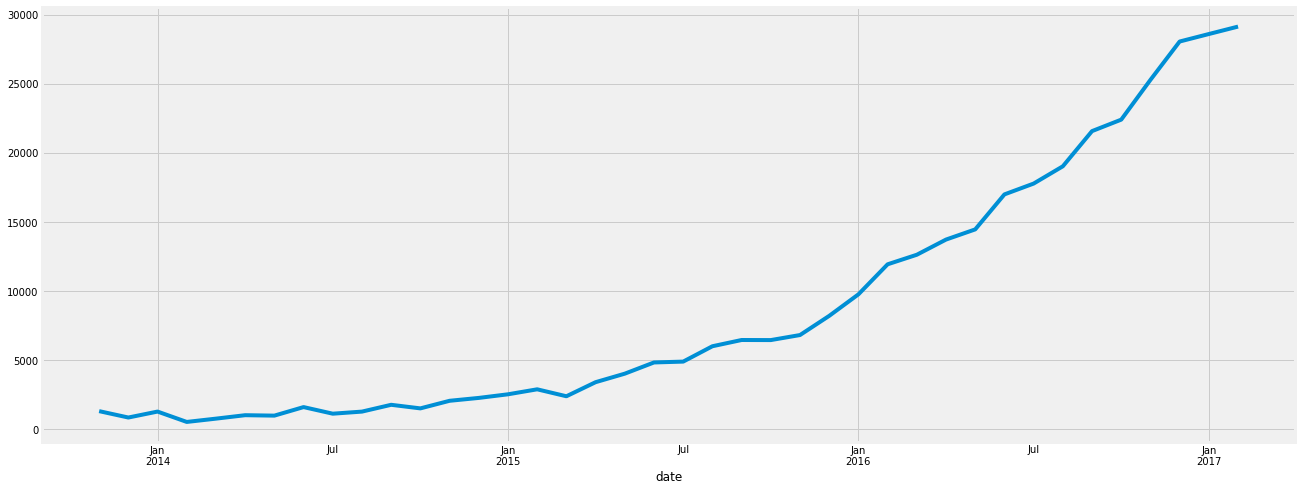

In [18]:
y.plot(figsize=(20, 8))
plt.show()

#### From the plot above (grouped by month) we can tell the trend at end that sales ceased to grow.

### Time-Series Forecasting with ARIMA

In [19]:
sale_week = sale['amount'].resample('W').mean()
sale_week = sale_week['2014-09-01':]

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sale_week,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2837.864123328295
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2523.4038967861857
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2248.3282124945717
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1992.397295405265
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2125.78646319752
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2098.511028421869
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1978.651363856453
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1919.6093161887447
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2732.656744295924
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2458.509797908505
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2165.777831744013
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1940.8492483702512
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2122.366310786308
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2445.9646287792953
ARIMA(0, 0, 1)x(1, 1, 0, 12)1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1676      0.140     -1.200      0.230      -0.441       0.106
ma.L1         -0.6460      0.114     -5.683      0.000      -0.869      -0.423
ma.S.L12      -0.7238      0.089     -8.167      0.000      -0.898      -0.550
sigma2      2.271e+06   3.12e+05      7.286      0.000    1.66e+06    2.88e+06


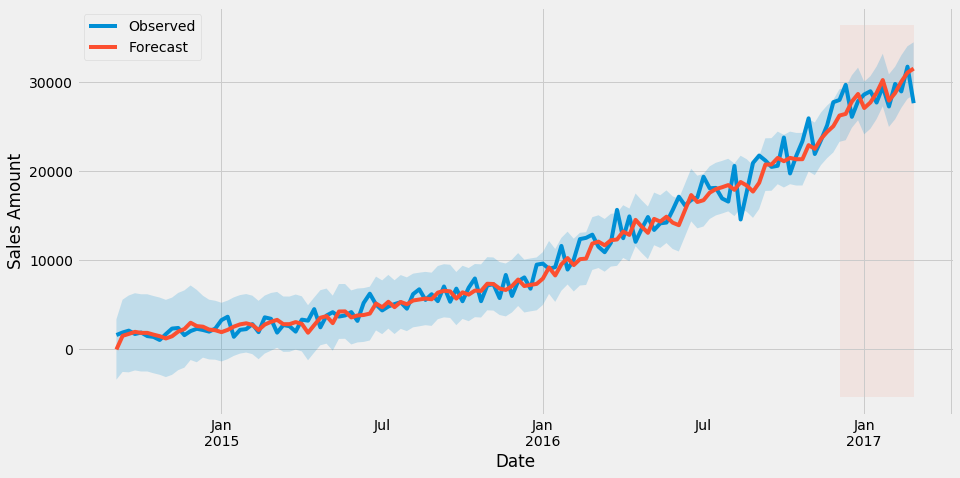

In [24]:
mod = sm.tsa.statespace.SARIMAX(sale_week,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
pred = results.get_prediction()
pred_ci = pred.conf_int()
ax = sale_week.plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=1, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], alpha=.2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-12-01'), sale_week.index[-1],
                 alpha=.08, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Sales Amount')
plt.legend(loc = 'upper left')
plt.style.use('fivethirtyeight')
plt.show()

#### From the comparison of forecasting data and observed data, we notice that observed sales is not in the range of confidence interval of the predicted sales. 

#### We can come to a conclusion that something went wrong, possibly either with engineering side or marketing side. 

In [25]:
"""
Another validation approach is to conduct t-test between two groups: predicted 
sales and observed sales. If the p-value is less than significance level 0.05,
we can reject the null hypothesis that the sales is within normal variance. 
And come to a conclusion that there is something wrong with the sales. 
"""

'\nAnother approach is to conduct t-test between two groups: predicted sales \nand observed sales. If the p-value is less than significance level 0.05,\nwe can reject the null hypothesis that the two groups are identical. That\nthe current sales is beyong variance. There is something wrong with the sales. \n'

#### Table join4 is joined by Table join3 & Table sale

In [28]:
# link sale, user, device and attribution into one table
sale_raw = pd.read_csv('sale.csv', parse_dates = ['date'])
join4 = pd.merge(
                join3,
                sale_raw,
                left_on = 'user_id',
                right_on = 'user_id',
                how = 'inner'
                )
join4.sort_values('date', ascending = False, inplace = True)

## Stragety of Root Cause Analysis

Create one experiment group with sales data from 2017-02-24 to 2017-02-26, and create 10 control groups each with 3 day sales data from most recent data.
####  For the engineering team, investigate two features: 
1. Device Type 2.  Operating System

####  For the marketing team, investigate the following: 
1. Sales amount distribution 2. Marketing attribution 

In [31]:
# Create experiment and control groups
target_days = join4[join4.date>='2017-02-24']
threeday_9 = join4[(join4.date<'2017-02-24') & (join4.date>='2017-02-21')]
threeday_8 = join4[(join4.date<'2017-02-21') & (join4.date>='2017-02-18')]
threeday_7 = join4[(join4.date<'2017-02-18') & (join4.date>='2017-02-15')]
threeday_6 = join4[(join4.date<'2017-02-15') & (join4.date>='2017-02-12')]
threeday_5 = join4[(join4.date<'2017-02-12') & (join4.date>='2017-02-09')]
threeday_4 = join4[(join4.date<'2017-02-09') & (join4.date>='2017-02-06')]
threeday_3 = join4[(join4.date<'2017-02-06') & (join4.date>='2017-02-03')]
threeday_2 = join4[(join4.date<'2017-02-03') & (join4.date>='2017-01-31')]
threeday_1 = join4[(join4.date<'2017-01-31') & (join4.date>='2017-01-28')]
threeday_0 = join4[(join4.date<'2017-01-28') & (join4.date>='2017-01-25')]


In [34]:
# Create a new column group to distinguish experiment & control groups
target_days['group'] = 'Experiment'
threeday_0['group'] = 'Control-0'
threeday_1['group'] = 'Control-1'
threeday_2['group'] = 'Control-2'
threeday_3['group'] = 'Control-3'
threeday_4['group'] = 'Control-4'
threeday_5['group'] = 'Control-5'
threeday_6['group'] = 'Control-6'
threeday_7['group'] = 'Control-7'
threeday_8['group'] = 'Control-8'
threeday_9['group'] = 'Control-9'
test = [target_days, threeday_9, threeday_8, threeday_7, threeday_6, threeday_5, threeday_4, threeday_3, threeday_2, threeday_1, threeday_0]
test = pd.concat(test)

In [35]:
# Check the operating system contribution in each group
os_by_group = test.groupby("group")['operating_system'].apply(lambda s: s.value_counts(normalize=False)).unstack()
os_by_group 

,10,20,7,8,9,BestOSEver!,Fire1,Fire2,Inferno,Jawbreaker,KitKat,Lollipop,Marshmallow
group,,,,,,,,,,,,,
Control-0,13.0,4.0,7.0,7.0,4.0,NaN,1.0,6.0,1.0,11.0,11.0,8.0,11.0
Control-1,7.0,12.0,7.0,11.0,8.0,NaN,4.0,1.0,4.0,11.0,7.0,7.0,17.0
Control-2,3.0,6.0,5.0,3.0,8.0,NaN,1.0,4.0,5.0,12.0,8.0,9.0,10.0
Control-3,15.0,7.0,9.0,9.0,7.0,NaN,3.0,5.0,1.0,12.0,8.0,8.0,8.0
Control-4,9.0,11.0,7.0,4.0,3.0,NaN,1.0,2.0,2.0,12.0,10.0,16.0,5.0
Control-5,6.0,5.0,5.0,6.0,4.0,NaN,NaN,4.0,1.0,8.0,6.0,11.0,7.0
Control-6,13.0,7.0,16.0,6.0,3.0,NaN,NaN,1.0,1.0,14.0,6.0,12.0,8.0
Control-7,8.0,12.0,10.0,8.0,7.0,NaN,5.0,5.0,2.0,16.0,6.0,14.0,11.0
Control-8,2.0,6.0,11.0,8.0,5.0,NaN,3.0,6.0,1.0,12.0,18.0,15.0,9.0


### Insight: 
Operating system - 7 is behaving poorly in Experiment group which might be a cause of low sales in the last three days.

In [37]:
device_type_by_group = test.groupby("group")['device_type'].apply(lambda s: s.value_counts(normalize=False)).unstack()
device_type_by_group 

,ActivehoursOS,Amazon Fire,Android,iOS
group,,,,
Control-0,NaN,8.0,41.0,35.0
Control-1,NaN,9.0,42.0,45.0
Control-2,NaN,10.0,39.0,25.0
Control-3,NaN,9.0,36.0,47.0
Control-4,NaN,5.0,43.0,34.0
Control-5,NaN,5.0,32.0,26.0
Control-6,NaN,2.0,40.0,45.0
Control-7,NaN,12.0,47.0,45.0
Control-8,NaN,10.0,54.0,32.0


### Insight: 
iOS platform might be a bit off. Somthing we could do is looking into the performance of the e-commence site on iOS device. 

In [39]:
campaign_by_group = test.groupby("group")['campaign'].apply(lambda s: s.value_counts(normalize=False)).unstack()
campaign_by_group.T

group,Control-0,Control-1,Control-2,Control-3,Control-4,Control-5,Control-6,Control-7,Control-8,Control-9,Experiment
0837KH,NaN,NaN,NaN,2.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0
0IBF68,2.0,4.0,NaN,1.0,1.0,2.0,NaN,1.0,2.0,NaN,NaN
15R3D0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,2.0,NaN,1.0
1BRIGC,2.0,NaN,NaN,1.0,NaN,NaN,NaN,4.0,1.0,1.0,NaN
1LYW47,1.0,1.0,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,2.0
1TNQYO,2.0,3.0,NaN,3.0,1.0,1.0,1.0,NaN,NaN,2.0,1.0
1TZQDZ,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN
1UV5W9,NaN,1.0,NaN,NaN,1.0,NaN,3.0,2.0,NaN,NaN,1.0
1ZDQF0,NaN,NaN,1.0,2.0,1.0,2.0,NaN,1.0,NaN,2.0,1.0
2IIPKA,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,1.0


### Insight: 
we might generate more insights by carefully investigating the performance of campaign in each group. 

In [36]:
sales_stats = pd.DataFrame({  
                    'control0': threeday_0.amount,
                    'control1': threeday_1.amount,
                    'control2': threeday_2.amount,
                    'control3': threeday_3.amount,
                    'control4': threeday_4.amount,
                    'control5': threeday_5.amount,
                    'control6': threeday_6.amount,
                    'control7': threeday_7.amount,
                    'control8': threeday_8.amount,
                    'control9': threeday_9.amount,
                    'experiment': target_days.amount})

#### Below is a table of how Sales amount distribute in each group.

In [38]:
sales_stats.describe()

,control0,control1,control2,control3,control4,control5,control6,control7,control8,control9,experiment
count,84.000000,96.000000,74.000000,92.000000,82.000000,63.000000,87.000000,104.000000,96.000000,74.000000,85.000000
mean,696.779005,539.055538,682.768252,659.904355,723.683559,732.584859,771.345266,689.023497,664.340207,625.269187,650.865426
std,490.986513,405.148901,472.066480,527.850662,609.147114,663.723292,531.358692,518.731337,434.286524,557.954244,507.052168
min,4.250000,5.500000,4.250000,3.500000,45.617228,5.892337,36.027298,30.475646,50.758881,11.450877,15.612209
25%,272.079712,220.003076,315.978948,180.123433,220.902422,247.809221,339.333221,320.091530,266.219855,183.510703,293.381927
50%,632.658431,506.289948,592.198574,556.191906,542.553946,519.509897,641.917220,554.958182,599.659889,482.313829,504.593726
75%,950.822814,756.448524,974.865316,1004.676681,1054.154235,1019.707971,1128.567874,964.261942,989.146766,906.959435,791.782509
max,2293.066295,1779.655855,2035.267679,2226.416377,2401.248118,2860.492163,2111.909919,2635.842371,2154.161114,2212.701234,2555.058228


### Insights: 
We can tell from the table above that Experiment group's 50 & 75 percentile of sales amount are much less than those of control groups, this means there are less big amount sale in the last couple of days. 

## Actionable insights

1. Let engineering team look into the performance of e-commence site on iOS Devices, for example finding out bugs that might decrease user experience. 
2. Let engineering team look into the e-commence site's adaption with Operating System - 7. 
3. Let marketing team research on users with high LTV(Life Time Value) and conduct user retention campaign if necessary. 
4. Let marketing team research on the most successful campaigns that generate the most profit.

## Future work 

1. User's LTV (Life time value) analysis & find out the Top 100 users with the highest LTV. 
2. Find the correlation between campaign & sales.
3. Do the experiment in different group size, such as 2 days and 5 days and see the difference in result from the one above.